Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dataroot = '../WaterLevelPrediction_SelectingModel//Data/'

In [7]:
!nvidia-smi

Mon Jan 15 20:02:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P0              N/A / ERR! |    603MiB /  4096MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Load the data

In [2]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

Time Series Cross Validation

In [3]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=6, test_size=365)
df = df.sort_index()

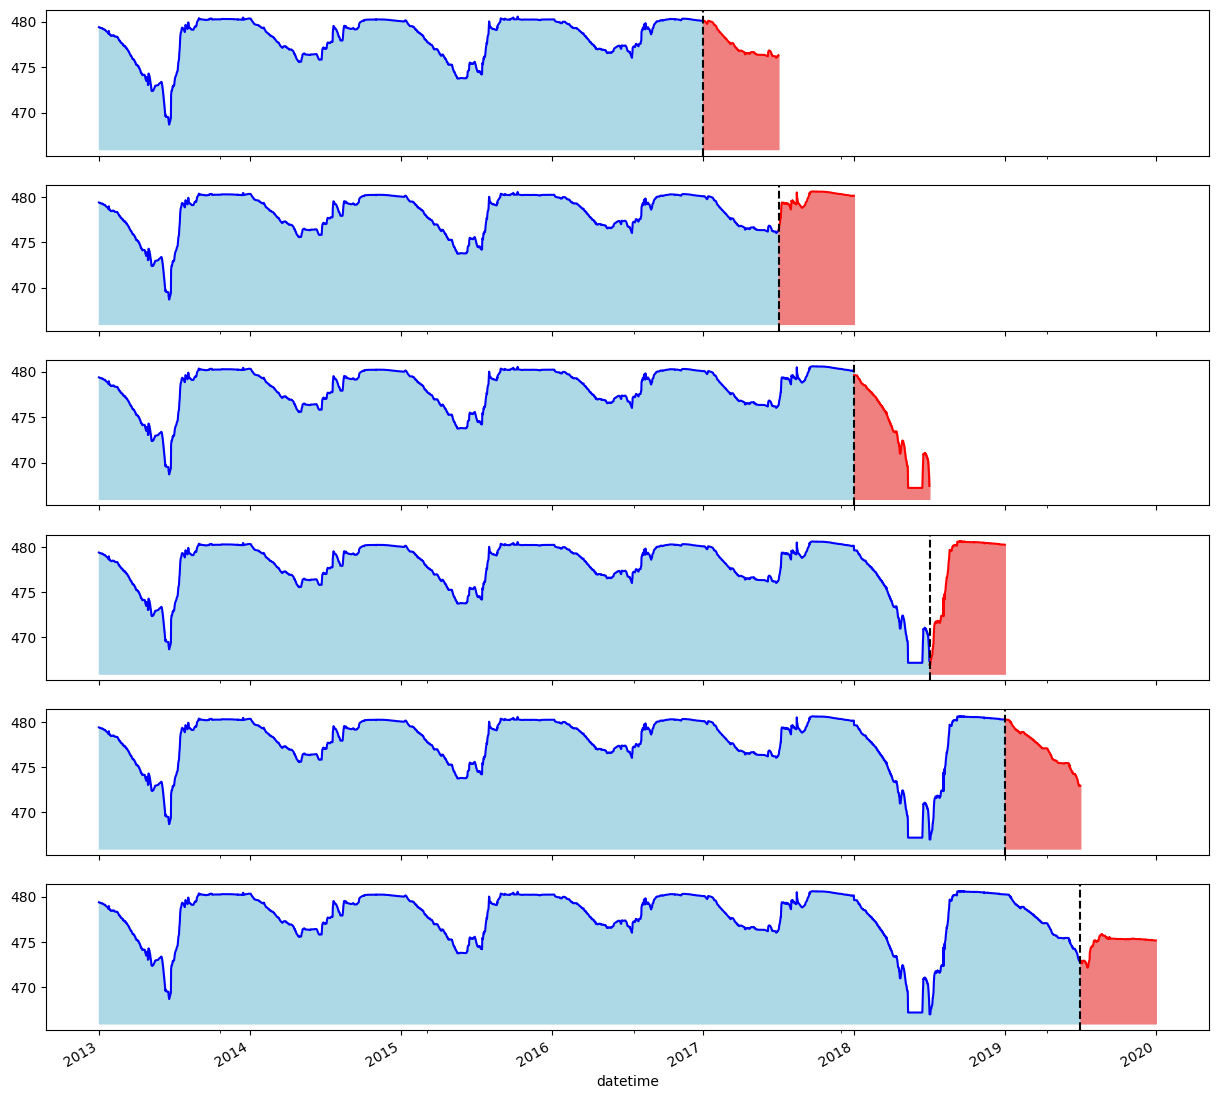

In [4]:
fig, axs = plt.subplots(6,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

Train the model with first features set

In [8]:
from xgboost import XGBRegressor

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['hour','precipitation','sluice_status']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    xgb_reg = XGBRegressor(n_estimators=100,
                           device = "cuda:0")
    xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=True)
    
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[0]	validation_0-rmse:2.18318	validation_1-rmse:1.62687
[1]	validation_0-rmse:2.15027	validation_1-rmse:1.70909
[2]	validation_0-rmse:2.13141	validation_1-rmse:1.77783
[3]	validation_0-rmse:2.11587	validation_1-rmse:1.83271


[4]	validation_0-rmse:2.10892	validation_1-rmse:1.87121
[5]	validation_0-rmse:2.10384	validation_1-rmse:1.89846
[6]	validation_0-rmse:2.09552	validation_1-rmse:1.92068
[7]	validation_0-rmse:2.08975	validation_1-rmse:1.93691
[8]	validation_0-rmse:2.08494	validation_1-rmse:1.94770
[9]	validation_0-rmse:2.08211	validation_1-rmse:1.94749
[10]	validation_0-rmse:2.08001	validation_1-rmse:1.94813
[11]	validation_0-rmse:2.07531	validation_1-rmse:1.95887
[12]	validation_0-rmse:2.07490	validation_1-rmse:1.96426
[13]	validation_0-rmse:2.07427	validation_1-rmse:1.96457
[14]	validation_0-rmse:2.07300	validation_1-rmse:1.96727
[15]	validation_0-rmse:2.07184	validation_1-rmse:1.96781
[16]	validation_0-rmse:2.06999	validation_1-rmse:1.96987
[17]	validation_0-rmse:2.06856	validation_1-rmse:1.97247
[18]	validation_0-rmse:2.06665	validation_1-rmse:1.97708
[19]	validation_0-rmse:2.06587	validation_1-rmse:1.97898
[20]	validation_0-rmse:2.06536	validation_1-rmse:1.98029
[21]	validation_0-rmse:2.06489	valida

Score

In [7]:
print(f'mean squared error across folds:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across folds:{np.mean(maes)}')
print(f'score for each folds:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each folds:{r2s}')

mean squared error across fold:3.2536080189539462
score for each fold:[2.0180685750047136, 1.6735427206064681, 6.366723578554815, 3.9099538920430557, 2.3692673987232302, 3.1840919487913943]
mean absolute error across fold:2.7208497927591684
score for each fold:[1.7379570078392539, 1.4775163139447776, 4.879141196891053, 3.2511914363495293, 1.9794196844231602, 2.9998731171072364]
r2 score across fold:-3.028216434610196
score for each fold:[-1.2263789177270592, -3.4639692707473175, -1.2477779749082858, 0.0032870215061041597, -0.4845831379014467, -11.749876327883172]


Create Lag Feature

In [8]:
def add_lag(df):
    target_map = df['water_level'].to_dict() #mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)
    return df

df = add_lag(df)

In [9]:
fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['hour','precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    xgb_reg = XGBRegressor(n_estimators=100,
                           device = "cuda:0")
    xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=True)
    
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[0]	validation_0-rmse:1.58330	validation_1-rmse:1.07314
[1]	validation_0-rmse:1.12160	validation_1-rmse:0.75302
[2]	validation_0-rmse:0.79874	validation_1-rmse:0.53111
[3]	validation_0-rmse:0.57030	validation_1-rmse:0.37456


[4]	validation_0-rmse:0.40978	validation_1-rmse:0.26395
[5]	validation_0-rmse:0.29797	validation_1-rmse:0.18758
[6]	validation_0-rmse:0.22056	validation_1-rmse:0.13709
[7]	validation_0-rmse:0.16752	validation_1-rmse:0.10198
[8]	validation_0-rmse:0.13032	validation_1-rmse:0.07917
[9]	validation_0-rmse:0.10547	validation_1-rmse:0.06602
[10]	validation_0-rmse:0.08971	validation_1-rmse:0.05814
[11]	validation_0-rmse:0.07964	validation_1-rmse:0.05374
[12]	validation_0-rmse:0.07261	validation_1-rmse:0.05185
[13]	validation_0-rmse:0.06810	validation_1-rmse:0.05085
[14]	validation_0-rmse:0.06445	validation_1-rmse:0.04994
[15]	validation_0-rmse:0.06211	validation_1-rmse:0.05013
[16]	validation_0-rmse:0.06081	validation_1-rmse:0.05023
[17]	validation_0-rmse:0.05946	validation_1-rmse:0.05035
[18]	validation_0-rmse:0.05707	validation_1-rmse:0.05076
[19]	validation_0-rmse:0.05587	validation_1-rmse:0.05112
[20]	validation_0-rmse:0.05521	validation_1-rmse:0.05105
[21]	validation_0-rmse:0.05479	valida

In [10]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.31526154184941496
score for each fold:[0.07008744224852291, 0.15358085935541976, 1.0663096353784152, 0.4171892792550818, 0.09265167284330665, 0.09175036201574356]
mean absolute error across fold:0.1824089762369803
score for each fold:[0.03650061871254422, 0.09710948202054877, 0.5981731492134009, 0.26877695580051436, 0.03944118217572822, 0.054452469499145464]
r2 score across fold:0.9787443048649213
score for each fold:[0.9973146081657538, 0.9624057195570186, 0.9369495647079156, 0.9886526847514651, 0.9977297018442512, 0.9894135501631238]


Hyperparameters tuning

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.5, 0.7, 1.0],
    'gamma':[0, 0.1, 0.2, 0.3]
}

xgb_reg = XGBRegressor(device = "cuda:0")
grid_search = GridSearchCV(estimator=xgb_reg, 
                           param_grid=param_grid,
                           cv=tss)
grid_search.fit(X_train, y_train)

TypeError: GridSearchCV.__init__() got an unexpected keyword argument 'device'

In [1]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

NameError: name 'grid_search' is not defined

In [ ]:
fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['hour','precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    xgb_reg = XGBRegressor(n_estimators=best_params['n_estimators'],
                           learning_rate=best_params['eta'],
                           max_depth=best_params['max_depth'],
                           subsample = best_params['subsample'],
                           early_stopping_rounds=20)
    xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=True)
    
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[0]	validation_0-rmse:2.13211	validation_1-rmse:1.45216
[1]	validation_0-rmse:2.02885	validation_1-rmse:1.38163
[2]	validation_0-rmse:1.93116	validation_1-rmse:1.31243
[3]	validation_0-rmse:1.83735	validation_1-rmse:1.24836
[4]	validation_0-rmse:1.75017	validation_1-rmse:1.18744
[5]	validation_0-rmse:1.66644	validation_1-rmse:1.12998
[6]	validation_0-rmse:1.58637	validation_1-rmse:1.07303
[7]	validation_0-rmse:1.51027	validation_1-rmse:1.02018
[8]	validation_0-rmse:1.43807	validation_1-rmse:0.96993
[9]	validation_0-rmse:1.36867	validation_1-rmse:0.92328
[10]	validation_0-rmse:1.30382	validation_1-rmse:0.87657
[11]	validation_0-rmse:1.24135	validation_1-rmse:0.83253
[12]	validation_0-rmse:1.18203	validation_1-rmse:0.79216
[13]	validation_0-rmse:1.12585	validation_1-rmse:0.75298
[14]	validation_0-rmse:1.07210	validation_1-rmse:0.71637


[15]	validation_0-rmse:1.02075	validation_1-rmse:0.68177
[16]	validation_0-rmse:0.97234	validation_1-rmse:0.64736
[17]	validation_0-rmse:0.92697	validation_1-rmse:0.61400
[18]	validation_0-rmse:0.88342	validation_1-rmse:0.58442
[19]	validation_0-rmse:0.84185	validation_1-rmse:0.55632
[20]	validation_0-rmse:0.80230	validation_1-rmse:0.52829
[21]	validation_0-rmse:0.76524	validation_1-rmse:0.50232
[22]	validation_0-rmse:0.72994	validation_1-rmse:0.47686
[23]	validation_0-rmse:0.69640	validation_1-rmse:0.45463
[24]	validation_0-rmse:0.66482	validation_1-rmse:0.43295
[25]	validation_0-rmse:0.63555	validation_1-rmse:0.41429
[26]	validation_0-rmse:0.60674	validation_1-rmse:0.39369
[27]	validation_0-rmse:0.57871	validation_1-rmse:0.37473
[28]	validation_0-rmse:0.55301	validation_1-rmse:0.35609
[29]	validation_0-rmse:0.52888	validation_1-rmse:0.33857
[30]	validation_0-rmse:0.50660	validation_1-rmse:0.32251
[31]	validation_0-rmse:0.48353	validation_1-rmse:0.30636
[32]	validation_0-rmse:0.46210	

In [ ]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.27285841850260145
score for each fold:[0.045803318119997924, 0.1212524066398361, 1.0094538868818277, 0.3078823701424695, 0.07085821232623377, 0.08190031690524342]
mean absolute error across fold:0.14892963789151772
score for each fold:[0.02991948041524055, 0.06536842826947824, 0.5717589796928523, 0.1395849107716192, 0.03805863053831245, 0.04888739766160367]
r2 score across fold:0.9838284530766291
score for each fold:[0.998853111698765, 0.9765669766773707, 0.9434940226207643, 0.9938198860366355, 0.9986721263617742, 0.991564595064466]


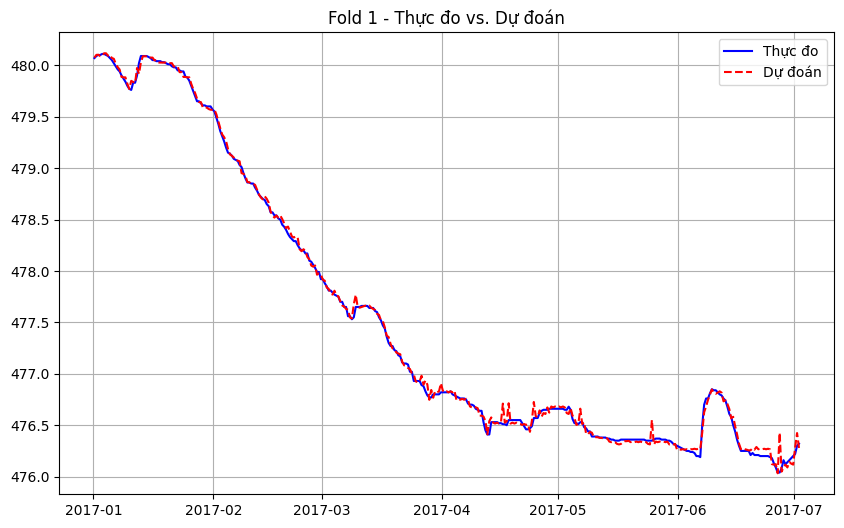

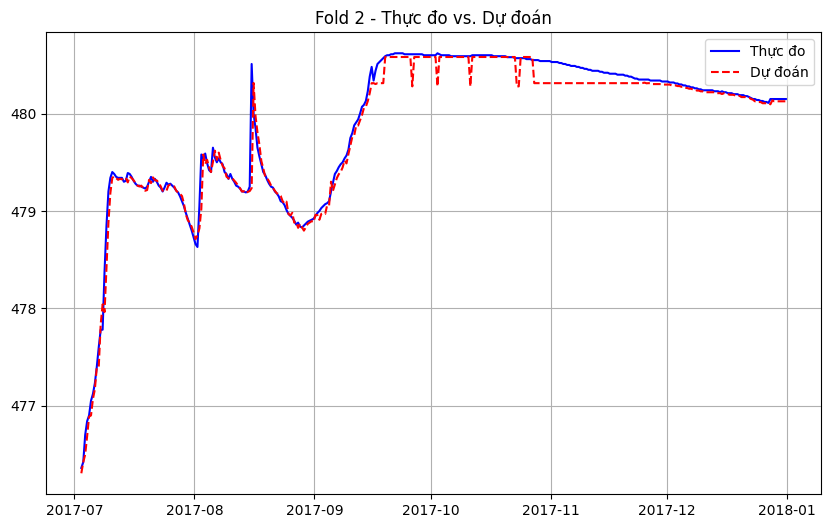

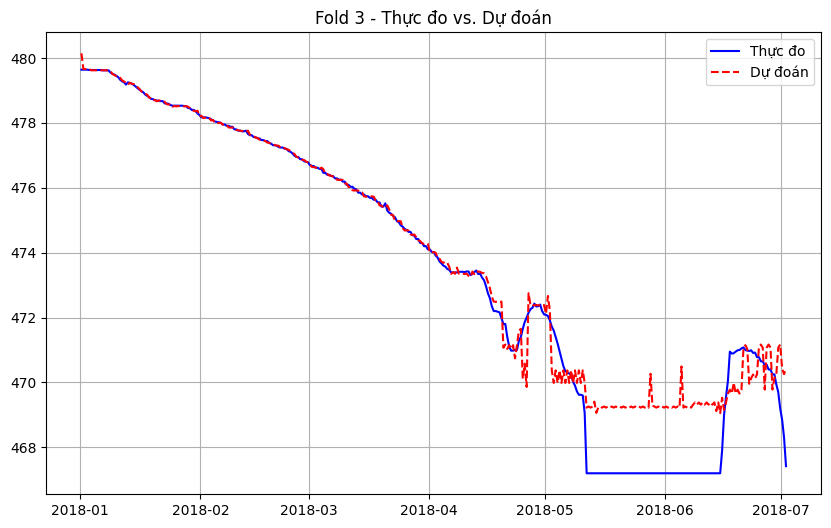

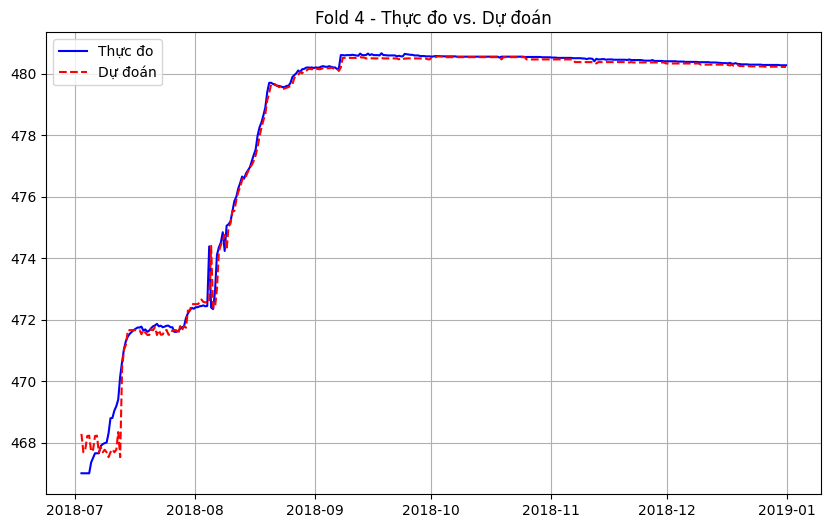

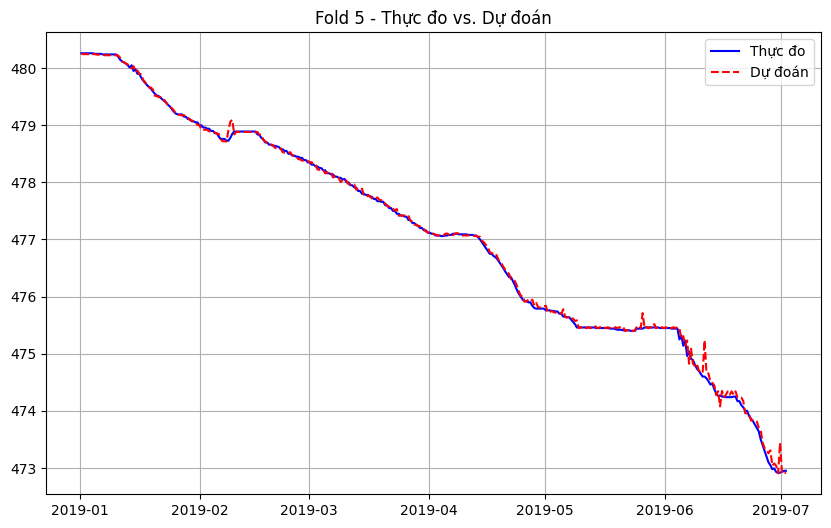

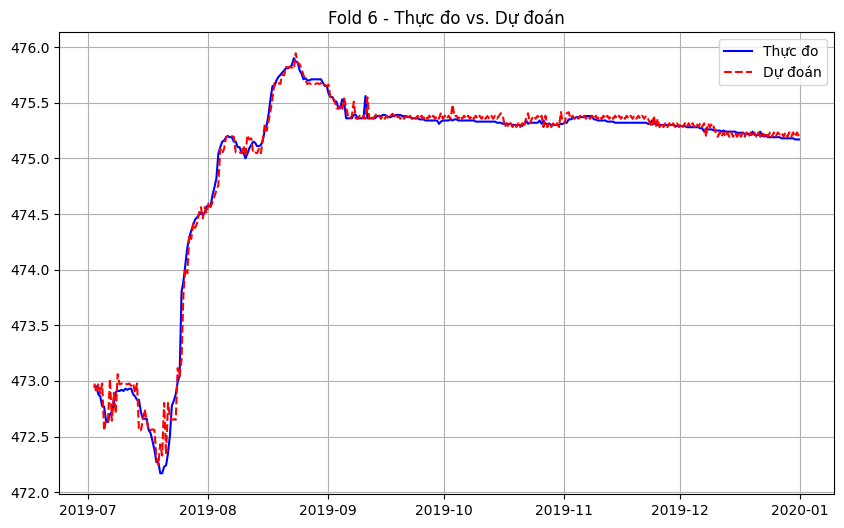

In [ ]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()